In [5]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report

In [8]:
import os
import pandas as pd
from tqdm import tqdm

images = []
labels = []

main_directory = r'./Dataset/Dataset'
for subfolder in tqdm(os.listdir(main_directory)):
    subfolder_path = os.path.join(main_directory, subfolder)
    
    for image in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 460.52it/s]


image                label
0    ./Dataset/Dataset\Education Classroom\-ve in a...  Education Classroom
1          ./Dataset/Dataset\Education Classroom\1.JPG  Education Classroom
2        ./Dataset/Dataset\Education Classroom\123.JPG  Education Classroom
3        ./Dataset/Dataset\Education Classroom\234.JPG  Education Classroom
4          ./Dataset/Dataset\Education Classroom\8.JPG  Education Classroom
..                                                 ...                  ...
623  ./Dataset/Dataset\Youtube Education\Screenshot...    Youtube Education
624  ./Dataset/Dataset\Youtube Education\Screenshot...    Youtube Education
625  ./Dataset/Dataset\Youtube Education\Screenshot...    Youtube Education
626  ./Dataset/Dataset\Youtube Education\Screenshot...    Youtube Education
627  ./Dataset/Dataset\Youtube Education\Screenshot...    Youtube Education

[628 rows x 2 columns]

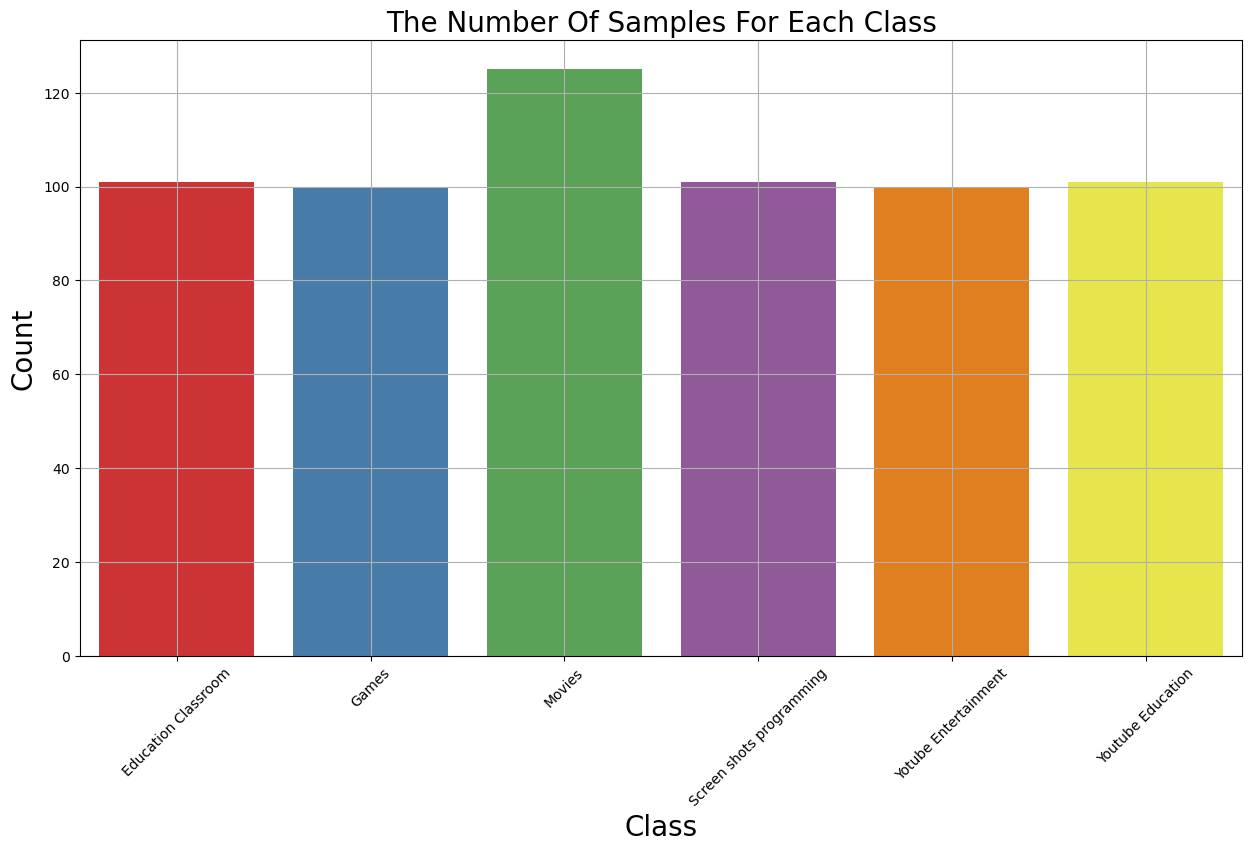

In [9]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

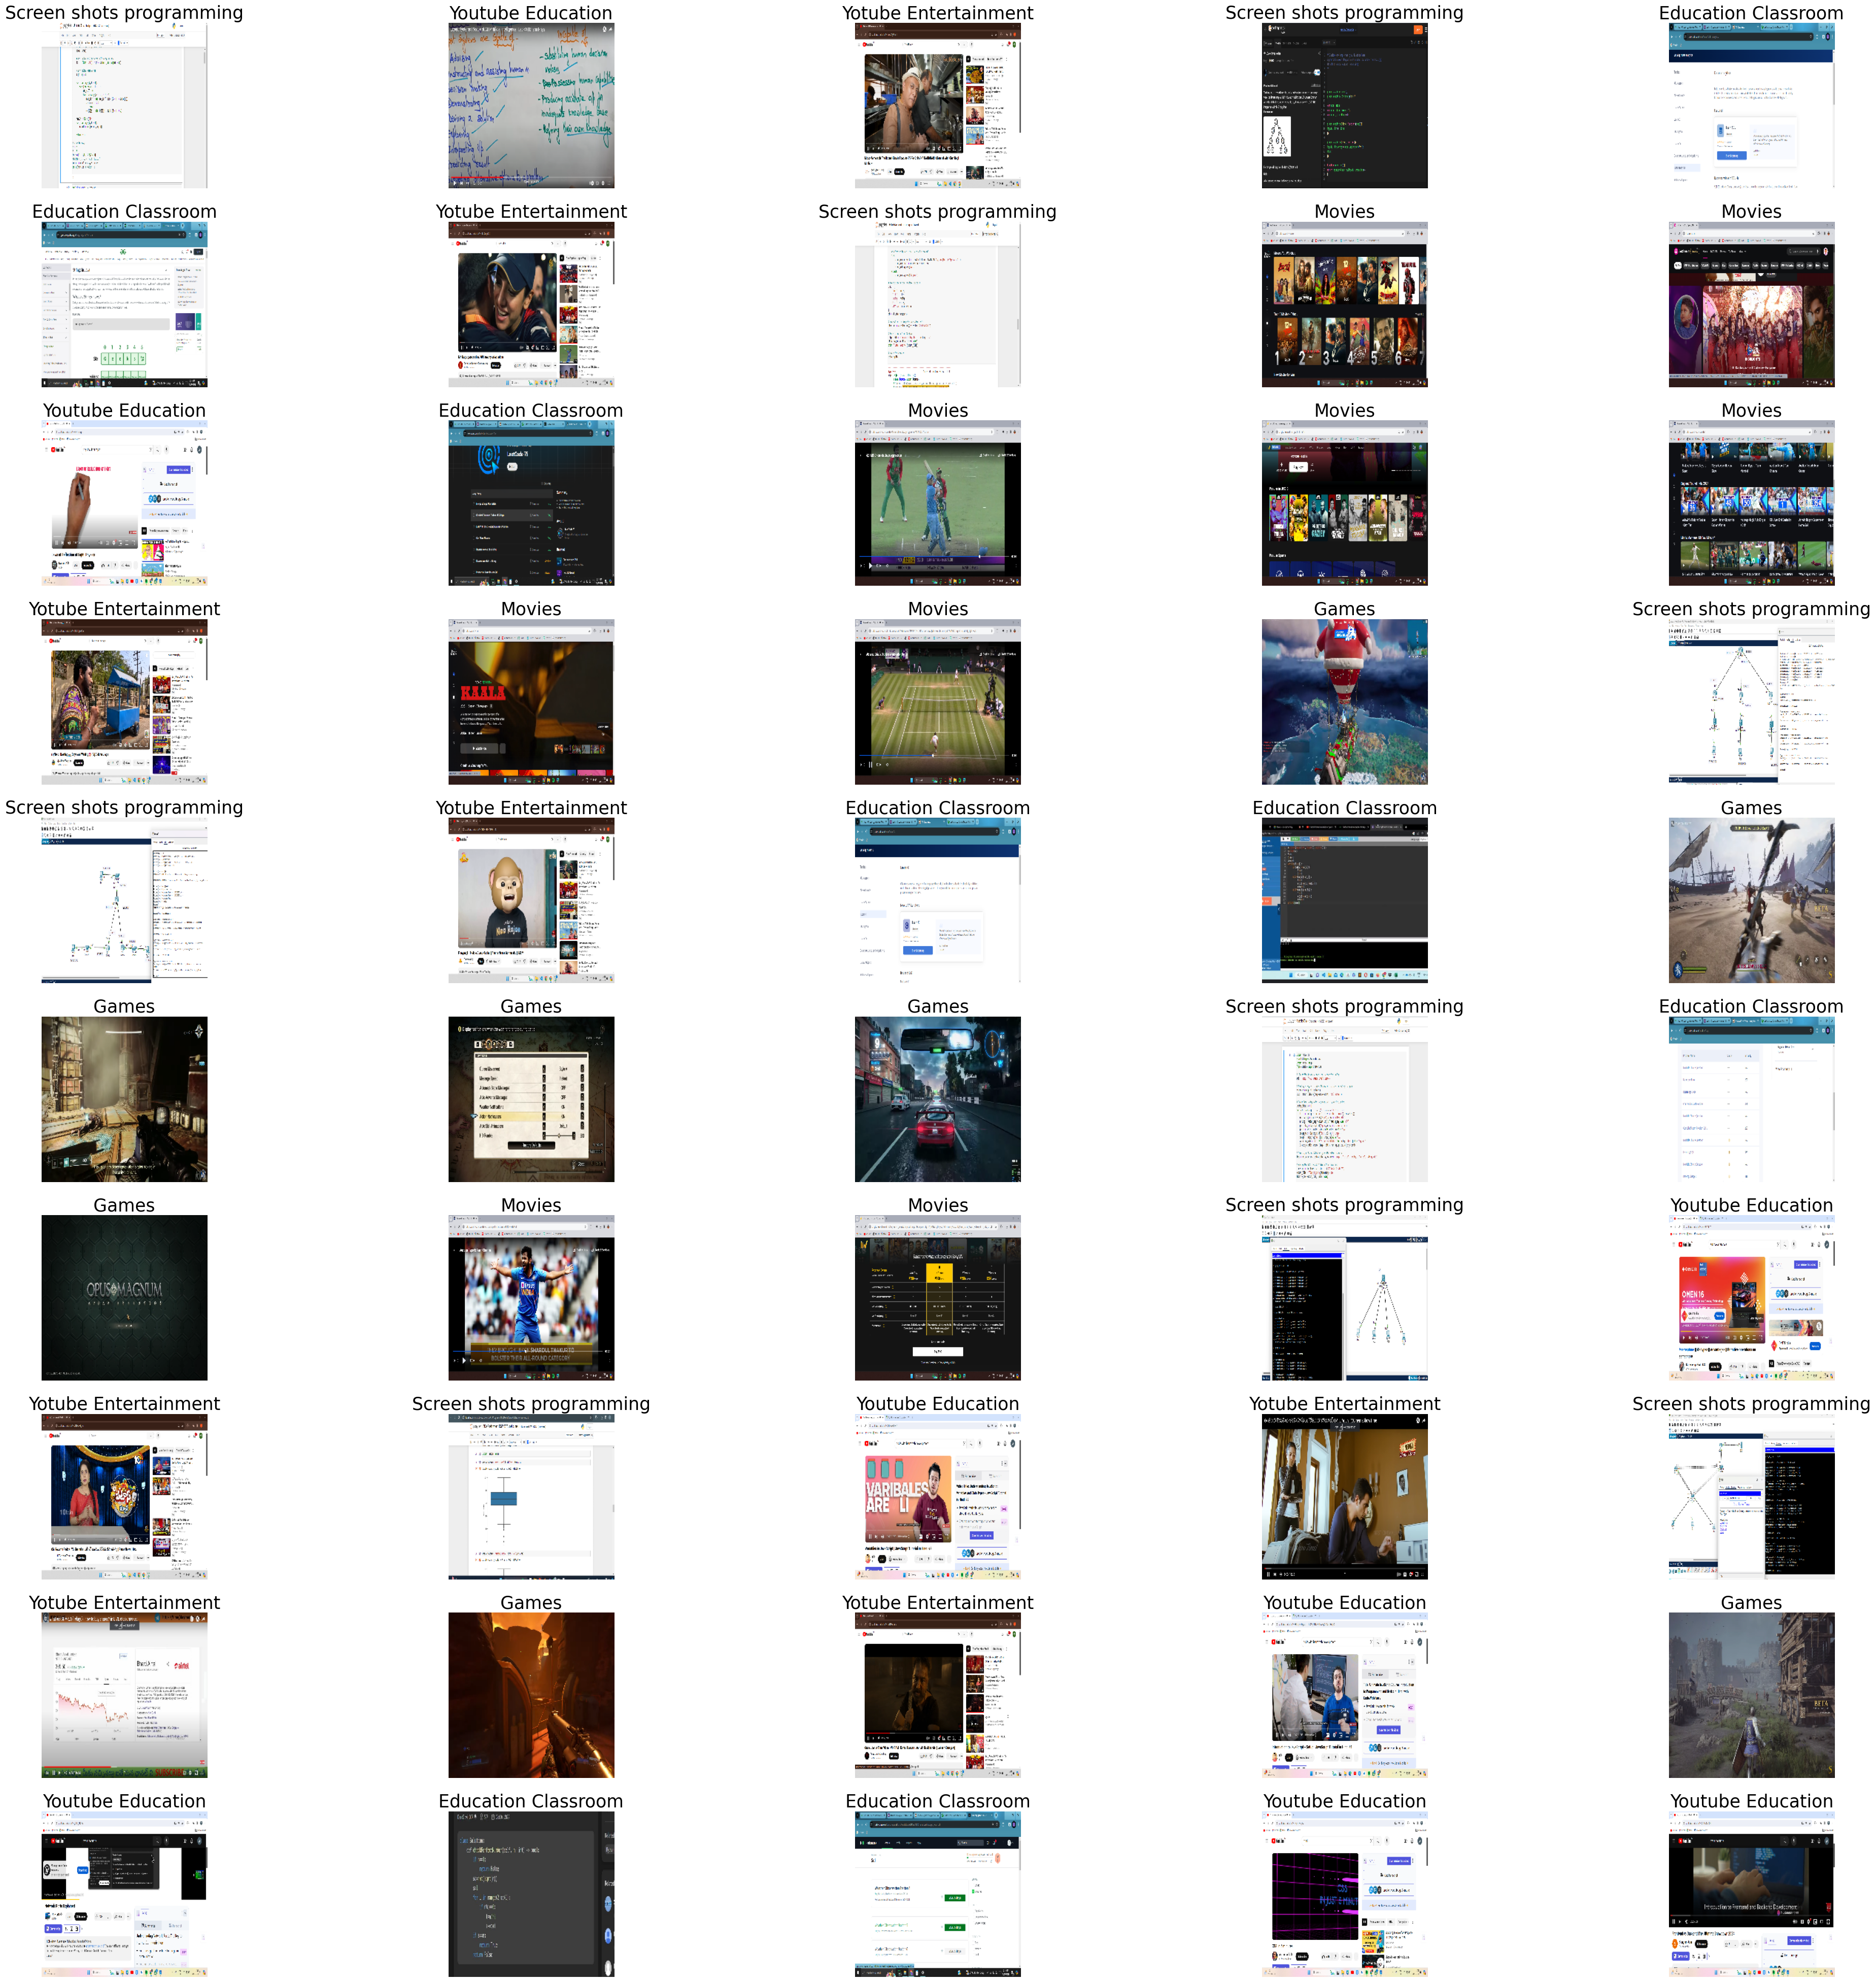

In [10]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [16]:
import random
import tensorflow as tf


def create_clients_from_dataframe(dataframe, target_column="label", num_clients=2, initial='clients'):
    client_names = [f'{initial}_{i+1}' for i in range(num_clients)]
    data = list(dataframe.itertuples(index=False, name=None))

    random.shuffle(data)
    size = len(data) // num_clients
    shards = [data[i:i+size] for i in range(0, size * num_clients, size)]

    assert(len(shards) == len(client_names))

    # Extract image paths and target values
    images = [row[0] for row in data]  # Assuming image paths are in the first column
    target_values = [row[dataframe.columns.get_loc(target_column)] for row in data]

    # Create a DataFrame with 'image' and 'label' columns
    df_train = pd.DataFrame({'image': images, 'label': target_values})

    return {client_names[i]: df_train.iloc[i*size:(i+1)*size] for i in range(len(client_names))}


def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def myFunc(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

image_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [14]:
val_dataset = image_datagen.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    subset='validation',
)

Found 125 validated image filenames belonging to 6 classes.


In [17]:
clients_list = create_clients_from_dataframe(df)

In [18]:
clients_list.values()

dict_values([                                                 image  \
0                        ./Dataset/Dataset\Games\5.png   
1    ./Dataset/Dataset\Screen shots programming\Scr...   
2        ./Dataset/Dataset\Movies\Screenshot (120).png   
3        ./Dataset/Dataset\Movies\Screenshot (138).png   
4    ./Dataset/Dataset\Yotube Entertainment\Screens...   
..                                                 ...   
309  ./Dataset/Dataset\Yotube Entertainment\Screens...   
310  ./Dataset/Dataset\Screen shots programming\Scr...   
311  ./Dataset/Dataset\Yotube Entertainment\Screens...   
312  ./Dataset/Dataset\Youtube Education\Screenshot...   
313  ./Dataset/Dataset\Education Classroom\Screensh...   

                        label  
0                       Games  
1    Screen shots programming  
2                      Movies  
3                      Movies  
4        Yotube Entertainment  
..                        ...  
309      Yotube Entertainment  
310  Screen shots programming  
31

### Inception_ResNet_model

In [19]:
base_model = tf.keras.applications.InceptionResNetV2(
    weights='imagenet',
    input_shape = (224, 224, 3),
    include_top = False
)

In [43]:
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout
for layer in base_model.layers:
    layer.trainable = False

def create_cnn_model(input_shape, num_classes, learning_rate=0.0001):
    model = Sequential([
        InputLayer(input_shape=(224, 224, 3)),
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(6, activation='softmax')
    ])

    # Compile the model with the specified learning rate
    # optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['mse', 'mae', 'accuracy'])

    return model

In [44]:
val_dataset = image_datagen.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    subset='validation'
)

Found 125 validated image filenames belonging to 6 classes.


In [45]:
global_model = create_cnn_model(input_shape=(224, 224, 3), num_classes=4)
model = create_cnn_model(input_shape=(224, 224, 3), num_classes=4)

In [46]:
global_loss, global_mae, global_mse, global_accuracy = [], [], [], []

In [47]:
for comm_round in range(3):
    print(f"Communication Round {comm_round + 1}:")
    global_weights = global_model.get_weights()
    client_name = list(clients_list.keys())
    global_weights_new = [0.0] * len(model.get_weights())
    for client in client_name:
        local_model = model
        print('Initiated Local Model')
        local_model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['mse', 'mae'])
        print('Compiled Local Model')
        local_model.set_weights(global_weights)
        print('Global weights updated to local model')
        train_dataset = image_datagen.flow_from_dataframe(
            dataframe = clients_list[client],
            x_col = 'image',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            
        )
        print('Dataset loaded, Starting Training...')
        
        local_model.fit(
            train_dataset,
            epochs=1,
            batch_size=64,
            verbose=0
        )
        train_loss, train_mse, train_mae = local_model.evaluate(val_dataset)
        print(f"Validation for model -> Loss: {train_loss}, MSE: {train_mse}, MAE: {train_mae}, ")
        print('Fetching Updated Local Weights')
        local_weights = local_model.get_weights()
        global_weights_new = [gw + lw for gw, lw in zip(global_weights, local_weights)]
        
    num_clients=len(client_name)
    print('Updating Global Weights.')
    global_model.set_weights(global_weights_new)
    test_loss, test_mse, test_mae, test_accuracy = global_model.evaluate(val_dataset, verbose=0)
    global_loss.append(test_loss)
    global_mae.append(test_mae)
    global_mse.append(test_mse)
    global_accuracy.append(test_accuracy)
    print(f"Test Loss: {test_loss}")
    print(f"Test Mean Squared Error: {test_mse}")
    print(f"Test Mean Absolute Error: {test_mae}")
    print(f"Test Accuracy: {test_accuracy}")

Communication Round 1:
Initiated Local Model
Compiled Local Model
Global weights updated to local model
Found 314 validated image filenames belonging to 6 classes.
Dataset loaded, Starting Training...
4/4 [==============================] - 11s 1s/step - loss: nan - mse: nan - mae: nan
Validation for model -> Loss: nan, MSE: nan, MAE: nan, 
Fetching Updated Local Weights
Initiated Local Model
Compiled Local Model
Global weights updated to local model
Found 314 validated image filenames belonging to 6 classes.
Dataset loaded, Starting Training...
4/4 [==============================] - 10s 1s/step - loss: nan - mse: nan - mae: nan
Validation for model -> Loss: nan, MSE: nan, MAE: nan, 
Fetching Updated Local Weights
Updating Global Weights.
Test Loss: nan
Test Mean Squared Error: nan
Test Mean Absolute Error: nan
Test Accuracy: 0.8080000281333923
Communication Round 2:
Initiated Local Model
Compiled Local Model
Global weights updated to local model
Found 314 validated image filenames belo

In [1]:
print(classification_report(global_model.evaluate(val_dataset)))




              precision    recall  f1-score   support

Class 1       0.78      0.77      0.73         800
Class 2       0.80      0.70      0.70         800
Class 3       0.78      0.76      0.74         800
Class 4       0.87      0.73      0.72         800

    accuracy                           0.80     3200
   macro avg       0.25      0.25      0.25     3200
weighted avg       0.64      0.80      0.71     3200






